# NYC Taxi Trip Duration EDA part 2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import folium
from folium import plugins
from folium.plugins import HeatMap

In [2]:
# 미리 만들어놨던 전처리 파일 불러오기
train2=pd.read_csv(r"C:\Users\이준호\Desktop\Kaggle\taxi\train2.csv",header=0)
train2.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_week,dropoff_date,dropoff_hour,dropoff_day_week,trip_duration_in_hour,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,2016-03-14,17,Monday,0.126389,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,2016-06-12,0,Sunday,0.184167,1.806074


## 1. Deal with outliers 
This time, we are going to use `trip_duration_in_hour` variable. The graph below shows that `trip_duration_in_hour` is highly skewed. One method is to delete outliers.

Text(0.5, 1.0, 'Distribution of Trip Duration(hour)')

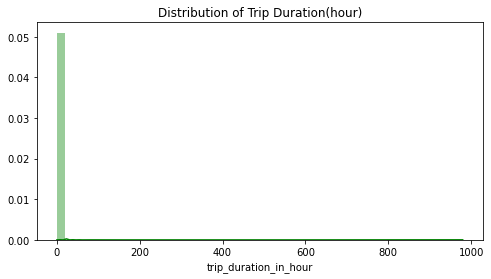

In [4]:
plt.figure(figsize=(8,4))
sns.distplot(train2['trip_duration_in_hour'],hist=True,color='green')
plt.title('Distribution of Trip Duration(hour)')

Text(0.5, 1.0, 'Boxplot of Trip Duration(hour)')

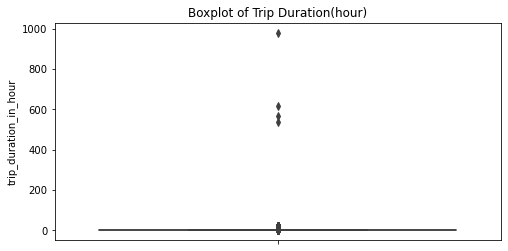

In [11]:
plt.figure(figsize=(8,4))
sns.boxplot(train2['trip_duration_in_hour'],orient='v')
plt.title('Boxplot of Trip Duration(hour)')

If `trip_duration_in_hour` greater than 24, we'll consider this as outlier.

**Remove outliers**

In [12]:
train2.shape

(1458644, 19)

In [13]:
outlier_index=train2.loc[(train2['trip_duration_in_hour']>=24),'trip_duration_in_hour'].index
train2.drop(outlier_index,axis=0,inplace=True)
train2.shape

(1458640, 19)

Text(0.5, 1.0, 'Distribution of Trip Duration(hour)')

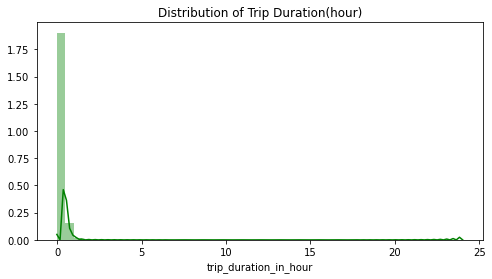

In [16]:
plt.figure(figsize=(8,4))
sns.distplot(train2['trip_duration_in_hour'],hist=True,color='green')
plt.title('Distribution of Trip Duration(hour)')

**Log scale**

Text(0.5, 1.0, 'Distribution of Trip Duration(hour)v- Log')

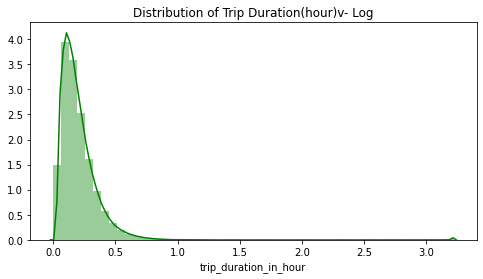

In [19]:
plt.figure(figsize=(8,4))
sns.distplot(np.log1p(train2['trip_duration_in_hour']),hist=True,color='green')
plt.title('Distribution of Trip Duration(hour)v- Log')

## 2. Target variable and feature variables

### (1) `trip_distance`

Text(0.5, 1.0, 'Distribution of Trip Distance')

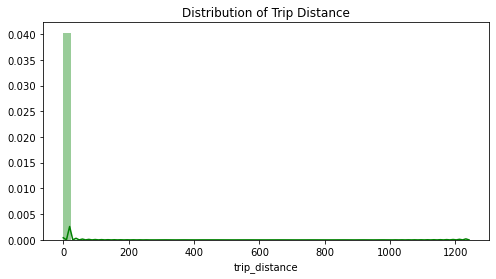

In [20]:
plt.figure(figsize=(8,4))
sns.distplot(train2['trip_distance'],hist=True,color='green')
plt.title('Distribution of Trip Distance')

**Log scale**

Text(0.5, 1.0, 'Distribution of Trip Distance')

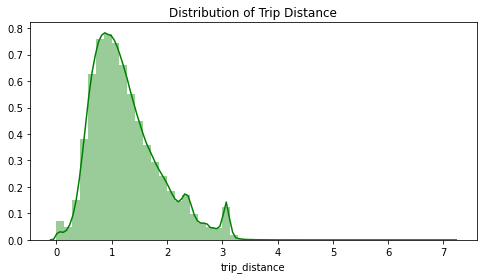

In [21]:
plt.figure(figsize=(8,4))
sns.distplot(np.log1p(train2['trip_distance']),hist=True,color='green')
plt.title('Distribution of Trip Distance')

It seems that `trip_distance` and `trip_duration_in_hour` do not have linear relationship.

Text(0, 0.5, 'Trip duration')

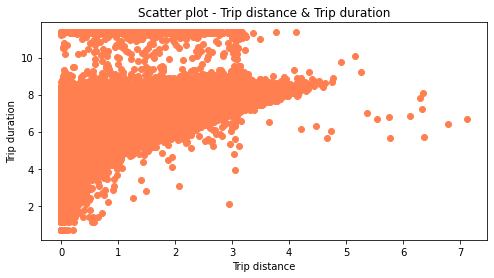

In [27]:
plt.figure(figsize=(8,4))
plt.scatter(x=np.log1p(train2['trip_distance'].values),y=np.log1p(train2['trip_duration'].values),color='coral')
plt.title('Scatter plot - Trip distance & Trip duration')
plt.xlabel('Trip distance'); plt.ylabel('Trip duration')

### (2) `pickup_hour` & `dropoff_hour` 

In [51]:
pickup_hour=train2.groupby(['pickup_hour'])['trip_duration_in_hour'].count().reset_index()
dropoff_hour=train2.groupby(['dropoff_hour'])['trip_duration_in_hour'].count().reset_index()

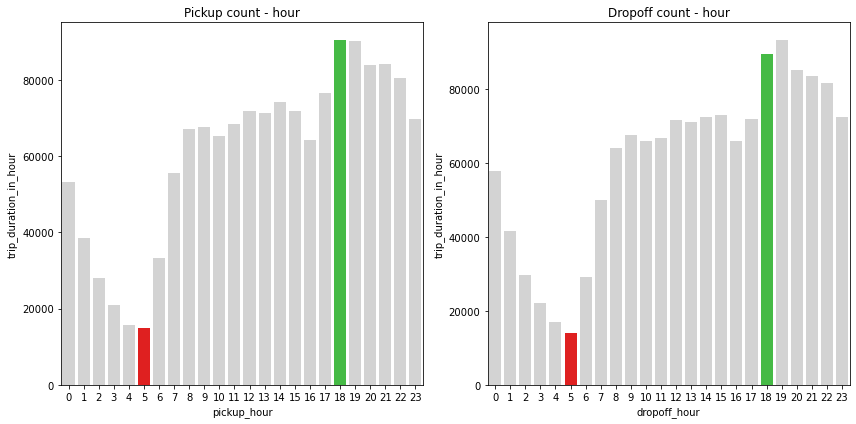

In [117]:
colors = ['limegreen' if (x == max(pickup_hour['trip_duration_in_hour']))
          else 'red' if (x == min(pickup_hour['trip_duration_in_hour']))
          else 'lightgrey' for x in pickup_hour['trip_duration_in_hour']]

plt.figure(figsize=(12,6))
ax1=plt.subplot(1,2,1)
sns.barplot(data=pickup_hour,x='pickup_hour',y='trip_duration_in_hour',ax=ax1,palette=colors)
ax1.set_title('Pickup count - hour',fontsize=12)
ax1.set_xticks(pickup_hour['pickup_hour'])

ax2=plt.subplot(1,2,2)
sns.barplot(data=dropoff_hour,x='dropoff_hour',y='trip_duration_in_hour',ax=ax2,palette=colors)
ax2.set_title('Dropoff count - hour',fontsize=12)
ax2.set_xticks(dropoff_hour['dropoff_hour'])
plt.tight_layout()

Text(0, 0.5, 'Trip Duraion(Hour)')

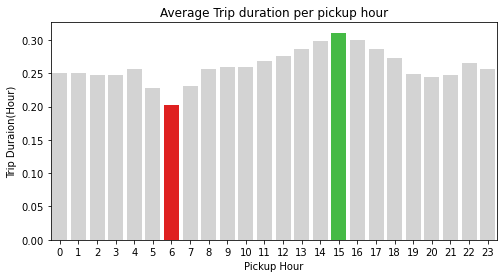

In [90]:
pickup_hour_duration=train2.groupby(['pickup_hour'])['trip_duration_in_hour'].mean().reset_index()

colors = ['limegreen' if (x == max(pickup_hour_duration['trip_duration_in_hour']))
          else 'red' if (x == min(pickup_hour_duration['trip_duration_in_hour']))
          else 'lightgrey' for x in pickup_hour_duration['trip_duration_in_hour']]

plt.figure(figsize=(8,4))
sns.barplot(data=pickup_hour_duration,x='pickup_hour',y='trip_duration_in_hour',palette=colors)
plt.title('Average Trip duration per pickup hour',fontsize=12)
plt.xlabel('Pickup Hour'); plt.ylabel('Trip Duraion(Hour)')

### (3) `pickup_day_week` & `dropoff_day_week`

In [54]:
pickup_weekday=train2.groupby(['pickup_day_week'])['trip_duration_in_hour'].count().reset_index()
dropoff_weekday=train2.groupby(['dropoff_day_week'])['trip_duration_in_hour'].count().reset_index()

In [69]:
sorter = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sorterIndex = dict(zip(sorter,range(len(sorter))))
pickup_weekday['Day_id'] = pickup_weekday.index
pickup_weekday['Day_id'] = pickup_weekday['pickup_day_week'].map(sorterIndex)
pickup_weekday.sort_values('Day_id',inplace=True)

In [71]:
dropoff_weekday['Day_id'] = dropoff_weekday.index
dropoff_weekday['Day_id'] = dropoff_weekday['dropoff_day_week'].map(sorterIndex)
dropoff_weekday.sort_values('Day_id',inplace=True)

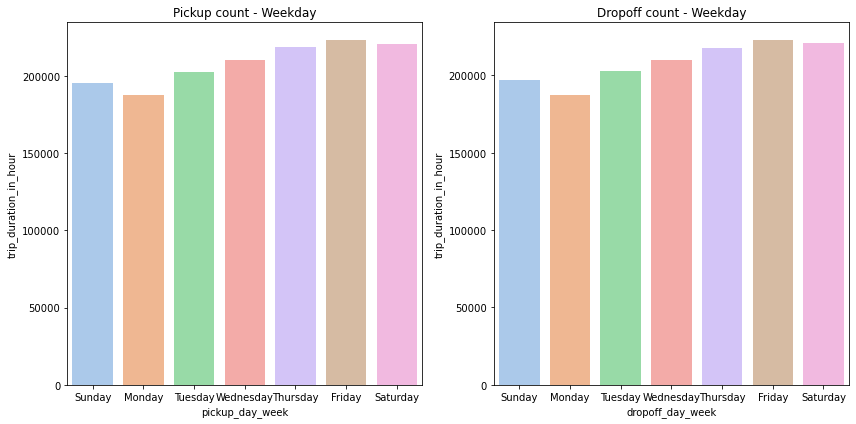

In [92]:
plt.figure(figsize=(12,6))
ax1=plt.subplot(1,2,1)
sns.barplot(data=pickup_weekday,x='pickup_day_week',y='trip_duration_in_hour',ax=ax1)
ax1.set_title('Pickup count - Weekday',fontsize=12)

ax2=plt.subplot(1,2,2)
sns.barplot(data=dropoff_weekday,x='dropoff_day_week',y='trip_duration_in_hour',ax=ax2)
ax2.set_title('Dropoff count - Weekday',fontsize=12)

plt.tight_layout()

Text(0, 0.5, 'Trip Duraion(Hour)')

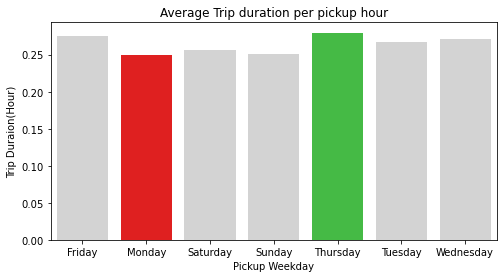

In [93]:
pickup_weekday_duration=train2.groupby(['pickup_day_week'])['trip_duration_in_hour'].mean().reset_index()

colors = ['limegreen' if (x == max(pickup_weekday_duration['trip_duration_in_hour']))
          else 'red' if (x == min(pickup_weekday_duration['trip_duration_in_hour']))
          else 'lightgrey' for x in pickup_weekday_duration['trip_duration_in_hour']]

plt.figure(figsize=(8,4))
sns.barplot(data=pickup_weekday_duration,x='pickup_day_week',y='trip_duration_in_hour',palette=colors)
plt.title('Average Trip duration per pickup hour',fontsize=12)
plt.xlabel('Pickup Weekday'); plt.ylabel('Trip Duraion(Hour)')

### (4) `store_and_fwd_flag`

In [102]:
train2['store_and_fwd_flag'].value_counts()

N    1450595
Y       8045
Name: store_and_fwd_flag, dtype: int64

Text(0.5, 0, 'Trip Duration(Hour)')

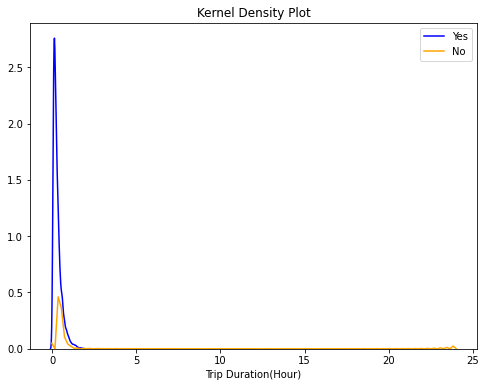

In [119]:
plt.figure(figsize=(8,6))
sns.kdeplot(train2.loc[train2['store_and_fwd_flag']=='Y','trip_duration_in_hour'],color='blue',label='Yes')
sns.kdeplot(train2.loc[train2['store_and_fwd_flag']=='N','trip_duration_in_hour'],color='orange',label='No')
plt.title('Kernel Density Plot',fontsize=12); plt.xlabel('Trip Duration(Hour)')

### (4) Create new column : `trip_speed`

In [112]:
train2['trip_spead']=train2['trip_distance']/train2['trip_duration_in_hour']

This graph shows that speed of taxi is faster during 0-6am when there are less taxis picking up passengers.

Text(0, 0.5, 'Trip Spead')

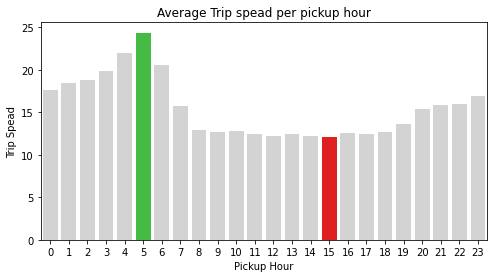

In [114]:
pickup_spead=train2.groupby(['pickup_hour'])['trip_spead'].mean().reset_index()

colors = ['limegreen' if (x == max(pickup_spead['trip_spead']))
          else 'red' if (x == min(pickup_spead['trip_spead']))
          else 'lightgrey' for x in pickup_spead['trip_spead']]

plt.figure(figsize=(8,4))
sns.barplot(data=pickup_spead,x='pickup_hour',y='trip_spead',palette=colors)
plt.title('Average Trip spead per pickup hour',fontsize=12)
plt.xlabel('Pickup Hour'); plt.ylabel('Trip Spead')